## Basic Training

In [94]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report

import numpy as np
import pandas as pd

In [95]:
hmhas = pd.read_csv('dataset/h_mas_train.csv')

In [96]:
# Drop Index

hmhas = hmhas.drop('Unnamed: 0', axis=1)

In [97]:
hmhas.columns

Index(['hosp1y', 'agey', 'ragender', 'momage', 'dadage', 'livsib', 'grchild',
       'shlt', 'vscan', 'cholst', 'weight', 'height', 'bmi', 'mobila',
       'grossa', 'adltot_m', 'walkra', 'walksa', 'push', 'lift', 'fallinj',
       'hip_m', 'hrtatte', 'rxdiabi', 'rxhrtat', 'rxstrok', 'rxhibp',
       'rxarthr', 'rxlung_m', 'cncrsurg'],
      dtype='object')

   hosp1y  Total
0     0.0  84050
1     1.0  11508


<AxesSubplot: xlabel='Total', ylabel='hosp1y'>

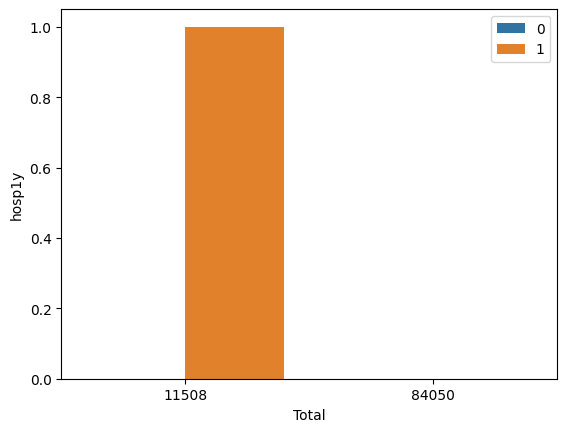

In [123]:
# Evaluate The Target Variable

import seaborn as sns
import matplotlib.pyplot as plt

df = hmhas

df_target = df.groupby(['hosp1y']).size().to_frame('Total').reset_index('hosp1y')

print(df_target)

sns.barplot(x='Total', y='hosp1y', hue=df_target.index, data=df_target)


In [99]:
hmhas.shape

(95558, 30)

# Preprocessing

In [101]:
df = hmhas

from sklearn.model_selection import train_test_split

X_train = df.drop("hosp1y", axis=1)

# Assign the 'target' column to y_train

y_train = df["hosp1y"]

# Remove the 'target' column for test
X_test = df.drop("hosp1y", axis=1)

# Assign the 'target' column to y_test
y_test = df["hosp1y"]

# separate dataset into train and test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)


In [102]:
# Drop Categorical :
categorical_cols = X_train.select_dtypes(include=['object']).columns

X_train = X_train.drop(categorical_cols, axis=1)
X_test = X_test.drop(categorical_cols, axis=1)
X_val = X_val.drop(categorical_cols, axis=1)

In [103]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Impute values for all columns with missing data
imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mean.fit(X_train)

n_train_df = imp_mean.transform(X_train)
t_val_df = imp_mean.transform(X_val)
t_test_df = imp_mean.transform(X_test)

# Scaling all Numerical features

scaler = StandardScaler()
scaler = scaler.fit(n_train_df)

t_train_df = scaler.transform(n_train_df)
t_val_df = scaler.transform(t_val_df)
t_test_df = scaler.transform(t_test_df)


In [17]:
%%time

#   - Create and fit (train) a Logistic Regression

log_reg = None
log_reg = LogisticRegression(C=0.01)
log_reg.fit(t_train_df, y_train)


CPU times: total: 469 ms
Wall time: 290 ms


LogisticRegression(C=0.01)

In [18]:
log_reg_train = log_reg.predict_proba(t_train_df)[:, 1]

In [19]:
roc_auc_train = roc_auc_score(y_true=y_train, y_score=log_reg_train)

print(f"Train ROC AUC Score: {roc_auc_train:.4f}") 

Train ROC AUC Score: 0.7385


# Multiple Training

In [20]:
import lightgbm as lgb

In [21]:
%%time

models = {
    "Logistic Regression": LogisticRegression(C=0.001),
    "      Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    "      LGBClassifier ": lgb.LGBMClassifier(learning_rate=0.2)
}

for name, model in models.items():
    model.fit(t_train_df, y_train)
    print(name + " trained.")

Logistic Regression trained.
      Random Forest trained.
[LightGBM] [Info] Number of positive: 9248, number of negative: 67198
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train set: 76446, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120974 -> initscore=-1.983236
[LightGBM] [Info] Start training from score -1.983236
      LGBClassifier  trained.
CPU times: total: 17.4 s
Wall time: 17.3 s


# Results

In [22]:
for name, model in models.items():
    y_pred = model.predict(t_test_df)
    acc = accuracy_score(y_test, y_pred)
    print(name + " Accuracy: {:.2f}%".format(acc * 100))

Logistic Regression Accuracy: 88.07%
      Random Forest Accuracy: 89.06%
      LGBClassifier  Accuracy: 89.84%


In [23]:
for name, model in models.items():
    y_pred = model.predict(t_test_df)
    f1 = f1_score(y_test, y_pred)
    print(name + " F1-Score: {:.5f}".format(f1))

Logistic Regression F1-Score: 0.10753
      Random Forest F1-Score: 0.17103
      LGBClassifier  F1-Score: 0.30327


## Neural NetWork Training

In [104]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [121]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [122]:
model = Sequential()

model.add(Flatten())

model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=['accuracy'])    

epochs = 30
batch_size = 32

my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{accuracy:.3f}.h5', save_best_only=True),
]

model.fit(t_train_df, y_train, class_weight=class_weight_dict, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=my_callbacks)

mlp = model

# Send the input data through the trained model to get the predictions
predictions = mlp.predict(t_test_df)

Epoch 1/30
2151/2151 [==============================] - 11s 5ms/step - loss: 0.6043 - accuracy: 0.6823 - val_loss: 0.6228 - val_accuracy: 0.6636
Epoch 2/30
2151/2151 [==============================] - 10s 4ms/step - loss: 0.5940 - accuracy: 0.6885 - val_loss: 0.5731 - val_accuracy: 0.7024
Epoch 3/30
2151/2151 [==============================] - 10s 5ms/step - loss: 0.5889 - accuracy: 0.6989 - val_loss: 0.6131 - val_accuracy: 0.6701
Epoch 4/30
2151/2151 [==============================] - 12s 5ms/step - loss: 0.5818 - accuracy: 0.7013 - val_loss: 0.5763 - val_accuracy: 0.6940
Epoch 5/30
2151/2151 [==============================] - 11s 5ms/step - loss: 0.5733 - accuracy: 0.7091 - val_loss: 0.5729 - val_accuracy: 0.7096
Epoch 6/30
2151/2151 [==============================] - 10s 5ms/step - loss: 0.5634 - accuracy: 0.7165 - val_loss: 0.5926 - val_accuracy: 0.7092
Epoch 7/30
2151/2151 [==============================] - 11s 5ms/step - loss: 0.5513 - accuracy: 0.7303 - val_loss: 0.5882 - val_ac

In [124]:
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 29)                0         
                                                                 
 dense (Dense)               (None, 512)               15360     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 146,945
Trainable params: 146,945
Non-trainable params: 0
_________________________________________________________________


In [125]:
predictions

array([[0.28810334],
       [0.00237069],
       [0.00613692],
       ...,
       [0.00152194],
       [0.4525897 ],
       [0.16670606]], dtype=float32)

## Classification Report

In [126]:
# Extract the probabilities

p_pred = predictions.flatten()

# Extract the Class labels
y_pred = np.where(p_pred > 0.5, 1, 0)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95     84050
         1.0       0.58      0.87      0.70     11508

    accuracy                           0.91     95558
   macro avg       0.78      0.89      0.82     95558
weighted avg       0.93      0.91      0.92     95558



## Confusion Matrix

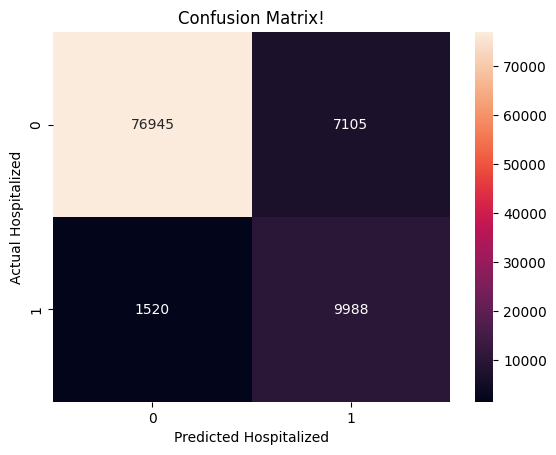

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

matc=confusion_matrix(y_test, y_pred)

ax = sns.heatmap(matc, annot=True, fmt='g')

ax.set_title('Confusion Matrix!')
ax.set_xlabel('Predicted Hospitalized')
ax.set_ylabel('Actual Hospitalized')

# Plot the confusion matrix

plt.show()

In [128]:
roc_auc_train = roc_auc_score(y_true=y_test, y_score=predictions)

print(f"Train ROC AUC Score: {roc_auc_train:.4f}") 

Train ROC AUC Score: 0.9379


## Model Test

In [135]:
# Assuming The Model Saved Has this name, Load For Predictions

model = keras.models.load_model('model.26-0.912.h5')

In [136]:
predictions

array([[0.28810334],
       [0.00237069],
       [0.00613692],
       ...,
       [0.00152194],
       [0.4525897 ],
       [0.16670606]], dtype=float32)

In [137]:
import joblib

# Save the scaler parameters to a file
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [138]:
# Load the scaler from the file
loaded_scaler = joblib.load('scaler.pkl')

In [143]:
import numpy as np

input_data = [50,1,60,60,2,5,
              1,50,0,60,1.5,24,
              4,4,5,1,1,5,5,
              0,0,
              0,0,1,0,1,0,1,1]

input_data = np.expand_dims(input_data, axis=0)  # Adding an extra dimension for batch size

# Transform new data using the loaded scaler
scaled_new_data = loaded_scaler.transform(input_data)

len(scaled_new_data[0]) 


29

In [146]:
pred_probability = model.predict(scaled_new_data)

print(pred_probability)

[[0.92299545]]


In [147]:
threshold = 0.9
if pred_probability >= threshold:
    prediction = "This person needs to be hospitalized next year."
else:
    prediction = "This person does not need to be hospitalized"

score = (pred_probability*100)


In [148]:
print(prediction)

score = np.around(score, 2)

s = str(score)
chars = [']', '['] 
result = s.translate(str.maketrans('', '', ''.join(chars)))
print('Score is '+result)    

This person needs to be hospitalized next year.
Score is 92.3
